# Imports

In [1]:
import pandas as pd
import pickle
import re

import torch
from torch import nn
from torch.optim import Adam

import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from gensim.models import Word2Vec

from random import shuffle

# Loading and Organzing Data

In [2]:
df = pd.read_csv('twcs/twcs.csv')
df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [3]:
df.columns

Index(['tweet_id', 'author_id', 'inbound', 'created_at', 'text',
       'response_tweet_id', 'in_response_to_tweet_id'],
      dtype='object')

In [4]:
df = df.drop(['created_at'], axis=1)

In [5]:
df.head()

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,@sprintcare I did.,4,6.0


In [6]:
df = df.set_index("tweet_id")

In [7]:
df.head(10)

,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id
tweet_id,,,,,
1,sprintcare,False,@115712 I understand. I would like to assist y...,2,3.0
2,115712,True,@sprintcare and how do you propose we do that,NaN,1.0
3,115712,True,@sprintcare I have sent several private messag...,1,4.0
4,sprintcare,False,@115712 Please send us a Private Message so th...,3,5.0
5,115712,True,@sprintcare I did.,4,6.0
6,sprintcare,False,@115712 Can you please send us a private messa...,"5,7",8.0
8,115712,True,@sprintcare is the worst customer service,"9,6,10",NaN
11,sprintcare,False,@115713 This is saddening to hear. Please shoo...,NaN,12.0
12,115713,True,@sprintcare You gonna magically change your co...,"11,13,14",15.0


In [8]:
df.loc[df.author_id == "115712"]

,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id
tweet_id,,,,,
2,115712,True,@sprintcare and how do you propose we do that,NaN,1.0
3,115712,True,@sprintcare I have sent several private messag...,1,4.0
5,115712,True,@sprintcare I did.,4,6.0
8,115712,True,@sprintcare is the worst customer service,"9,6,10",NaN
1292,115712,True,@sprintcare I've sent several private messages...,1294,1291.0
1295,115712,True,@sprintcare I sent it twice now to apparently ...,NaN,1294.0
1293,115712,True,@115714 @sprintcare how can I get in touch wit...,"1291,1296,1297",NaN
3185,115712,True,@sprintcare complete ineptness!,3184,3186.0
3186,115712,True,@sprintcare I am not surprised because nothing...,3185,3187.0


In [9]:
df.columns

Index(['author_id', 'inbound', 'text', 'response_tweet_id',
       'in_response_to_tweet_id'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2811774 entries, 1 to 2987950
Data columns (total 5 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   author_id                object 
 1   inbound                  bool   
 2   text                     object 
 3   response_tweet_id        object 
 4   in_response_to_tweet_id  float64
dtypes: bool(1), float64(1), object(3)
memory usage: 109.9+ MB


In [11]:
df.in_response_to_tweet_id = df.in_response_to_tweet_id.fillna(-1)
df.in_response_to_tweet_id = df.in_response_to_tweet_id.astype(int)

In [12]:
df.response_tweet_id = df.response_tweet_id.apply(lambda x: x if x != "NaN" else -1)
df.response_tweet_id.describe()

count     1771145
unique    1771145
top             2
freq            1
Name: response_tweet_id, dtype: object

In [13]:
from dataclasses import dataclass

@dataclass
class Tweet:

    id: int
    author_id: str | int
    is_customer: bool
    text: str
    response_tweets_ids: list[int] | None
    in_response_to_tweet_id: int | None


In [14]:
#Map all to tweet objects
tweets: list[Tweet] = []


def row_to_tweet(df: pd.Series):
    return Tweet(
        id=df.index,
        author_id=df.author_id,
        is_customer=df.inbound,
        text=df.text,
        response_tweets_ids=list(map(int, df.response_tweet_id.split(' '))) if df.response_tweet_id != 'NaN' else None,
        in_response_to_tweet_id= df.in_response_to_tweet_id if df.in_response_to_tweet_id != -1 else None
    )


In [15]:
conversation_starts = df.loc[df.in_response_to_tweet_id == -1]

In [16]:
conversation_starts

,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id
tweet_id,,,,,
8,115712,True,@sprintcare is the worst customer service,"9,6,10",-1
18,115713,True,@115714 y’all lie about your “great” connectio...,17,-1
20,115715,True,"@115714 whenever I contact customer support, t...",19,-1
29,115716,True,actually that's a broken link you sent me and ...,28,-1
31,115717,True,"Yo @Ask_Spectrum, your customer service reps a...",30,-1
...,...,...,...,...,...
2987942,823867,True,Hai @AirAsiaSupport #asking how many days need...,2987941,-1
2987944,823868,True,@AirAsiaSupport \n\nI am unable to do web chec...,2987943,-1
2987946,524544,True,@VirginTrains Hope you are well? Does the 9.30...,2987945,-1


In [17]:
conversation_starts.author_id.describe()

count             794335
unique            631099
top       Safaricom_Care
freq                 606
Name: author_id, dtype: object

### Here, we generate the conversations objects from the tweets

In [18]:
@dataclass
class ConversationEntry:

    is_customer: bool
    text: str

@dataclass
class Conversation:

    customer_id: int
    brand_name: str
    entries: list[ConversationEntry] # this alternates between customer entry and agent entry

In [19]:
import os

convos: list[Conversation] = list()

if os.path.exists('convos.pkl'):
    with open('convos.pkl', 'rb') as f:
        convos = pickle.load(f)
else:
    num_conversation = 0
    for (index, row) in conversation_starts.iterrows():

        # if the thread is not started by a customer, then skip it
        if not row.iloc[0].isdigit():
            continue

        convo_entries: list[ConversationEntry] = []

        tweet_queue = [(index, row)]
        convo_entry: ConversationEntry | None = None

        brand_name = ""

        while len(tweet_queue) > 0:
            tweet_id, tweet_row = tweet_queue.pop(0)

            is_customer = tweet_row.iloc[0].isdigit()
            if convo_entry == None:
                convo_entry = ConversationEntry(is_customer, text='')
            if convo_entry.is_customer != is_customer:
                convo_entries.append(convo_entry)
                convo_entry = ConversationEntry(is_customer, text='')


            if not is_customer:
                brand_name = tweet_row.iloc[0] 

            text = str(tweet_row.iloc[2]).strip()
            convo_entry.text += ' ' + text

            response_tweet_ids = list(map(int, str(tweet_row.iloc[3]).split(','))) if not pd.isnull(tweet_row.iloc[3]) else []
            for res in response_tweet_ids:
                if res not in df.index:
                    continue
                new_row = df.loc[res].squeeze()
                tweet_queue.append((res, new_row))

        if convo_entry != None:
            convo_entries.append(convo_entry)

        convo = Conversation(
            customer_id=int(row.iloc[0]),
            brand_name=brand_name,
            entries=convo_entries
        )
        convos.append(convo)

        num_conversation += 1
        if num_conversation % 10000 == 0:
            print("Conversation #", num_conversation)

In [20]:
# Save convos
with open('convos.pkl', 'wb') as f:
    pickle.dump(convos, f)



In [21]:
len(convos)

787346

In [22]:
def print_convo(convo: Conversation):
    for entry in convo.entries:
        print(convo.customer_id if entry.is_customer else convo.brand_name, end = '> ')
        print(entry.text)

In [23]:
print_convo(convos[1])

115713>  @115714 y’all lie about your “great” connection. 5 bars LTE, still won’t load something. Smh.
sprintcare>  @115713 H there! We'd definitely like to work with you on this, how long have you been experiencing this issue? -AA
115713>  @sprintcare Since I signed up with you....Since day 1
sprintcare>  @115713 We understand your concerns and we'd like for you to please send us a Direct Message, so that we can further assist you. -AA
115713>  @sprintcare You gonna magically change your connectivity for me and my whole family ? 🤥 💯
sprintcare>  @115713 This is saddening to hear. Please shoot us a DM, so that we can look into this for you. -KC @115713 I would really like to work with you to have this resolved. Kindly send us a DM. I'm here for you! -ResolutionSup SR @115713 Hi, my name is Shantel, I'm a resolution supervisor here with Sprint. Your issues was brought to my attention.  1/2 -ResolutionSup SR


In [24]:
@dataclass
class ConversationsStatistics:
    
    num_convos: int
    total_num_messages: int
    avg_num_messages: int
    avg_msg_len_charachters: int


def get_convos_statistics(convos: list[Conversation]):
    
    # 1
    num_convos = len(convos)

    # 2
    total_num_messages = 0
    total_msgs_len = 0

    for c in convos:
        total_num_messages += len(c.entries)
        for e in c.entries:
            total_msgs_len += len(e.text)
    
    return ConversationsStatistics(
        num_convos, 
        total_num_messages, 
        total_num_messages / num_convos, 
        total_msgs_len / total_num_messages
    )

In [25]:
get_convos_statistics(convos)

ConversationsStatistics(num_convos=787346, total_num_messages=2336382, avg_num_messages=2.9674145801210647, avg_msg_len_charachters=133.88451118010667)

# Cleaning

In [26]:
def clean_message(text: str):
    # Remove links
    text = re.sub(r'http\S+', '', text)
    
    # Lowercase the text
    text = text.lower()
    
    # Remove mentions 
    text = re.sub(r'@\w+', '', text)
    
    # Remove non-ascii characters (to remove emojis, and other languages maybe)
    text = ''.join(char for char in text if ord(char) < 128)

    return text.strip()
    

Before cleaning

In [27]:
print_convo(convos[100])

115861>  Hello, internet. Can someone explain why this symbol keeps appearing on my phone and when I️ try to type the letter I️? Also @AppleSupport https://t.co/QKwvTLtiN7
AppleSupport>  @115861 You're in the right place; we'll do all we can to help. To start, let us know what iOS version is installed via DM: https://t.co/GDrqU22YpT
115861>  @AppleSupport @115861 We’re going to need you to share the answers Angela. I️ can’t stand this! @115862 @AppleSupport I will! @115861 @115862 @AppleSupport I️ upgraded. I️t didn’t work.
AppleSupport>  @115860 Reach out to us via DM, and we can take a look at this with you. https://t.co/GDrqU22YpT
115861>  @115860 @115862 @AppleSupport Didn’t work for me either😔


Cleaning

In [28]:
import dataclasses

def clean_convos(convos: list[Conversation], copy=True):
    if copy:
        new_convos: list[Conversation] = []

    for c in convos:
        if copy:
            new_entries: list[ConversationEntry] = []

        for e in c.entries:
            cleaned_message = clean_message(e.text)
            if copy:
                new_entries.append(dataclasses.replace(e, text=cleaned_message))
            else:
                e.text = cleaned_message

        if copy:
            new_convos.append(dataclasses.replace(c, entries = new_entries))

    if copy:
        return new_convos            


In [29]:
cleaned_convos = clean_convos(convos, copy=True)

After Cleaning

In [30]:
print_convo(cleaned_convos[100])

115861> hello, internet. can someone explain why this symbol keeps appearing on my phone and when i try to type the letter i? also
AppleSupport> you're in the right place; we'll do all we can to help. to start, let us know what ios version is installed via dm:
115861> were going to need you to share the answers angela. i cant stand this!   i will!    i upgraded. it didnt work.
AppleSupport> reach out to us via dm, and we can take a look at this with you.
115861> didnt work for me either


In [31]:
cleaned_convos_stats = get_convos_statistics(cleaned_convos)
cleaned_convos_stats

ConversationsStatistics(num_convos=787346, total_num_messages=2336382, avg_num_messages=2.9674145801210647, avg_msg_len_charachters=112.84678704081782)

# Tokenizing and Generating Embeddings

The dataset is too large, so we will only use a few companies

In [32]:
used_brands = set(["AmazonHelp", "AppleSupport", "Uber_Support", "SpotifyCares"])
filtered_convos = list( filter(lambda convo: convo.brand_name in used_brands, cleaned_convos) )

shuffle(filtered_convos)

filtered_convos = filtered_convos[: int(0.5 * len(filtered_convos))] # take 50% of the tweets

In [33]:
len(filtered_convos)

115611

In [34]:
filtered_convos_stats = get_convos_statistics(filtered_convos)
filtered_convos_stats

ConversationsStatistics(num_convos=115611, total_num_messages=360835, avg_num_messages=3.121113042876543, avg_msg_len_charachters=110.86719691825904)

In [35]:
stops = set(stopwords.words('english'))

def tokenize_message(text, remove_stops: bool = False):

    tokens = word_tokenize(text)

    if remove_stops:
        tokens = [word for word in tokens if word not in stops]

    return tokens

In [36]:
tokenize_message(cleaned_convos[0].entries[0].text, remove_stops=False)

['is', 'the', 'worst', 'customer', 'service']

In [37]:
EMBEDDING_SIZE = 100

In [38]:
w2v = Word2Vec(
    vector_size=EMBEDDING_SIZE,
    window=5,
    sg=1,
    epochs=10,
    workers=4
)

Special Tokens

In [39]:
# client input tokens
BOC = "<boc>"
EOC = "<eoc>"

# agent output tokens
BOA = "<boa>"
EOA = "<eoa>"

# padding
PAD = "<pad>"


In [40]:
def tokenized_sentences_generator(convos: list[Conversation]):

    for c in convos:
        for e in c.entries:
            yield tokenize_message(e.text) 

In [41]:
print(list(tokenized_sentences_generator(cleaned_convos[0:2])))

[['is', 'the', 'worst', 'customer', 'service'], ['i', 'would', 'love', 'the', 'chance', 'to', 'review', 'the', 'account', 'and', 'provide', 'assistance', '.', 'can', 'you', 'please', 'send', 'us', 'a', 'private', 'message', ',', 'so', 'that', 'i', 'can', 'gain', 'further', 'details', 'about', 'your', 'account', '?', 'hello', '!', 'we', 'never', 'like', 'our', 'customers', 'to', 'feel', 'like', 'they', 'are', 'not', 'valued', '.'], ['i', 'did', '.', 'the', 'only', 'way', 'i', 'can', 'get', 'a', 'response', 'is', 'to', 'tweet', 'apparently'], ['please', 'send', 'us', 'a', 'private', 'message', 'so', 'that', 'we', 'can', 'further', 'assist', 'you', '.', 'just', 'click', 'message', 'at', 'the', 'top', 'of', 'your', 'profile', '.'], ['i', 'have', 'sent', 'several', 'private', 'messages', 'and', 'no', 'one', 'is', 'responding', 'as', 'usual'], ['i', 'understand', '.', 'i', 'would', 'like', 'to', 'assist', 'you', '.', 'we', 'would', 'need', 'to', 'get', 'you', 'into', 'a', 'private', 'secured

In [42]:
w2v.build_vocab(tokenized_sentences_generator(filtered_convos))

In [43]:
w2v.train(
    list(tokenized_sentences_generator(filtered_convos)), 
    total_examples=w2v.corpus_count, 
    epochs=10
)

(62090882, 86842620)

In [44]:
w2v.wv.most_similar("app")

[('application', 0.7931230068206787),
 ('appstore', 0.66998690366745),
 ('yelp', 0.669537365436554),
 ('safari', 0.6518566012382507),
 ('tab', 0.6378610730171204),
 ('switcher', 0.6331617832183838),
 ('podcast', 0.6321865320205688),
 ('reopening', 0.6314966678619385),
 ('google', 0.630513608455658),
 ('re-installed', 0.6302210688591003)]

In [45]:
w2v.wv["apple"]

array([-0.11068089, -0.31094307,  0.18202882,  0.01357247,  0.04913061,
       -0.17180687,  0.42468843,  0.05860467, -0.1031799 , -0.12140831,
        0.3649895 , -0.02619116, -0.64161396, -0.2572995 ,  0.04888123,
       -0.01932447,  0.30139804, -0.20511597, -0.5395796 , -0.73336756,
        0.5674775 , -0.119105  , -0.05053532,  0.31559527, -0.04778261,
        0.14721437, -0.02586155, -0.03229638, -0.09497796,  0.433001  ,
        0.38103205,  0.01172661,  0.32765827, -0.3837844 ,  0.0692039 ,
        0.8054997 ,  0.284461  ,  0.34670034, -0.17424574,  0.01288162,
        0.16616914, -0.2717708 ,  0.11054961, -0.36503026,  0.1650472 ,
       -0.1654424 , -0.22571294, -0.28632703,  0.4830518 , -0.2529409 ,
        0.4283536 ,  0.04878951, -0.46517673, -0.18254961,  0.4264278 ,
        0.14436823,  0.03037901,  0.3938734 , -0.07817879,  0.01715388,
        0.1135712 ,  0.04466423,  0.6882897 ,  0.27804503,  0.34623984,
        0.8512855 ,  0.13173118, -0.13198961, -0.328914  ,  0.36

In [46]:
print(f'Number of tokens: {len(w2v.wv)}')

Number of tokens: 21716


In [47]:
BOC_VEC = np.zeros(100)
BOC_VEC[-1] = 1

EOC_VEC = np.zeros(100)
EOC_VEC[-2] = 1

BOA_VEC = np.zeros(100)
BOA_VEC[-3] = 1

EOA_VEC = np.zeros(100)
EOA_VEC[-4] = 1

PAD_VEC = np.zeros(100)


w2v.wv.add_vectors(
    [BOC, EOC, BOA, EOA, PAD],
    [BOC_VEC, EOC_VEC, BOA_VEC, EOA_VEC, PAD_VEC]
)

In [48]:
w2v.build_vocab([BOC, EOC, BOA, EOA, PAD], update=True)

In [49]:
w2v.wv[EOA]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
      dtype=float32)

In [50]:
w2v.save("word_embeddings")

# Dataset Pipeline

We try to identify a suitable sequence length

In [51]:
all_sentences_tokens = list( tokenized_sentences_generator(filtered_convos) )

num_sentences = len(all_sentences_tokens)
total_sentence_len = sum(map(lambda x: len(x), all_sentences_tokens))

print("Number of sentences: ", num_sentences)
print("Average sentence length in tokens: ", total_sentence_len / num_sentences)

Number of sentences:  360835
Average sentence length in tokens:  24.06712763451439


In [52]:
SEQ_LENGTH = 50

In [53]:
# Takes an alternating list of questions and answers to preapare it for the model as input,
# This assumes the last string is a question
# returns a list of tokens containing word and special tokens
def prepare_context_tokens(context: list[str], clean=False):
    
    is_q = True
    rem_seq_length = SEQ_LENGTH

    tokens = []

    for i in reversed(context):
        
        if rem_seq_length < 3: break

        if is_q:
            tokens.append(EOC)
        else:
            tokens.append(EOA)

        rem_seq_length -= 1

        if clean: i = clean_message(i)
        i = tokenize_message(i)
        max_new_tokens = min(rem_seq_length - 1, len(i))
        tokens += i[:-max_new_tokens:-1]

        rem_seq_length -= max_new_tokens

        if is_q:
            tokens.append(BOC)
        else:
            tokens.append(BOA)
        rem_seq_length -= 1

        is_q = not is_q

    num_padding = SEQ_LENGTH - len(tokens)
    tokens = list(reversed(tokens)) + [PAD] * num_padding
    
    return tokens

ex1 = list(map(lambda x: x.text, filtered_convos[200].entries[0:5]))
len(prepare_context_tokens(ex1))

50

In [54]:
VOCAB_SIZE = len(w2v.wv)

def prepare_answer_vector(ans: str):
    """
    Takes an answer (string) as a parameter
    and returns a tensor of shape (SEQ_LENGTH, EMBEDDING_SIZE)
    
    this is to be used in the decoder part

    this also adds the <BOA> token
    """
    tokens = [BOA] + tokenize_message(ans)

    rem_len = SEQ_LENGTH - len(tokens)
    if rem_len > 0:
        tokens = tokens + [PAD] * rem_len
    elif rem_len < 0:
        tokens = tokens[:SEQ_LENGTH]

    sequences = []
    for t in tokens:
        if t not in w2v.wv: t = PAD
        sequences.append(w2v.wv[t])
        

    return torch.Tensor(np.array(sequences))

In [55]:
sample_ans = prepare_answer_vector("hello i am here to help")
sample_ans[4], sample_ans.shape

(tensor([ 0.1164, -0.0453, -0.1673,  0.0953,  0.0262, -0.2497,  0.2528,  0.2945,
         -0.3477, -0.1630, -0.2664, -0.2703, -0.1411,  0.2000, -0.0524, -0.2414,
          0.8918, -0.1272,  0.6767, -0.8528, -0.5542,  0.2872,  0.6297,  0.2211,
         -0.3138, -0.1921, -0.6014,  0.0069,  0.1067, -0.2886,  0.7568,  0.1041,
          0.1572, -0.3095, -0.4743,  0.2358,  0.4765, -0.2584,  0.1821, -0.4653,
          0.2727,  0.0490,  0.2243, -0.3184, -0.3180,  0.0935,  0.3439,  0.0723,
          0.4054, -0.1458, -0.0325, -0.1087, -0.5407,  0.3363, -0.0721,  0.0297,
         -0.2577, -0.4629, -0.2107, -0.4120, -0.1746,  0.2716,  0.0655,  0.1739,
         -0.0964,  0.3114,  0.2085,  0.2832, -0.1810, -0.3909, -0.2627,  0.0070,
         -0.1071, -0.2945,  0.7515, -0.0742,  0.0035, -0.0756, -0.0241,  0.0140,
          0.4596, -0.0969, -0.4196,  1.1208, -0.1663,  0.2689,  0.2885,  0.2776,
          0.0222, -0.4662,  0.0380,  0.2391, -0.1892, -0.0232,  0.4248, -0.0625,
         -0.2105,  0.0547, -

In [56]:
def get_answer_tokens(ans: str):

    tokens = tokenize_message(ans) + [EOA]

    rem_len = SEQ_LENGTH - len(tokens)
    if rem_len > 0:
        tokens = tokens + [EOA] * rem_len
    elif rem_len < 0:
        tokens = tokens[:SEQ_LENGTH]
    
    token_indices = []
    for i in tokens:
        if i not in w2v.wv: i = EOA

        token_indices.append(w2v.wv.get_index(i))
    
    return torch.Tensor(token_indices).type(torch.int32)

In [57]:
ex_ans_tokens = get_answer_tokens("hello i am here to help")
ex_ans_tokens

tensor([  327,     5,   144,    25,     1,    24, 21719, 21719, 21719, 21719,
        21719, 21719, 21719, 21719, 21719, 21719, 21719, 21719, 21719, 21719,
        21719, 21719, 21719, 21719, 21719, 21719, 21719, 21719, 21719, 21719,
        21719, 21719, 21719, 21719, 21719, 21719, 21719, 21719, 21719, 21719,
        21719, 21719, 21719, 21719, 21719, 21719, 21719, 21719, 21719, 21719],
       dtype=torch.int32)

In [58]:
def get_embeddings_for_tokens(tokens: list[str]):

    out = list()
    for i in tokens:
        if i in w2v.wv:
            out.append(w2v.wv[i])
        else:
            out.append(w2v.wv[PAD])
    
    return torch.Tensor(np.array(out))

In [59]:
get_embeddings_for_tokens(prepare_context_tokens(ex1))

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  0.0000,  0.0000],
        [-0.2214,  0.1025, -0.0749,  ..., -0.3781, -0.0293,  0.3091],
        [ 0.2325,  0.1746, -0.0170,  ..., -0.3943,  0.2373,  0.0866],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [60]:
from torch.utils.data import Dataset


class QADataset(Dataset):

    def __init__(self, convos: list[Conversation]):
        
        self.dataset = []

        for c in convos:
            contexts, answers = QADataset.generate_convo_qa_pairs(c)
            
            for con, ans in zip(contexts, answers):
                self.dataset.append((con, ans))

    @staticmethod
    def generate_convo_qa_pairs(convo: Conversation):
        """
        Returns a list of all questions, along with a list of all answers to each question
        """
        entries = convo.entries
        
        contexts = []
        answers = []
        for i in range(len(entries) - 1):
            entry = entries[i]
            if entry.is_customer: # this is a question
                contexts.append(entries[i].text)
                answers.append(entries[i+1].text)

        return contexts, answers

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index: int):
        
        con, ans = self.dataset[index]
        prepped_con = get_embeddings_for_tokens(prepare_context_tokens([con]))
        prepped_ans = prepare_answer_vector(ans)

        # these are the indices of the tokens that the model should output starting from <BOA> token
        # these will be used to calculate the loss
        target_tokens = get_answer_tokens(ans) 
        
        return prepped_con, prepped_ans, target_tokens.type(torch.int32)

In [61]:
QADataset.generate_convo_qa_pairs(filtered_convos[1000])

(['on peut pas payer en espce sur  ?  urgent'],
 ["hi there! we're here to help. can you please provide more details of what the specific issue is? from there we'll be able to assist further."])

In [62]:
from random import shuffle

TRAIN_SPLIT_RATIO = 0.8

num_train_convos = int(TRAIN_SPLIT_RATIO * len(filtered_convos))

train_convos = filtered_convos[:num_train_convos]
test_convos = filtered_convos[num_train_convos:]

len(train_convos), len(test_convos)

(92488, 23123)

In [63]:
train_dataset = QADataset(train_convos)
test_dataset = QADataset(test_convos)

In [64]:
len(train_dataset), len(test_dataset)

(137504, 34536)

In [65]:
print("Shape of questions: ", train_dataset[0][0].shape)
print("Shape of answers: ", train_dataset[0][1].shape)
print("Shape of answer indices", train_dataset[0][2].shape)

Shape of questions:  torch.Size([50, 100])
Shape of answers:  torch.Size([50, 100])
Shape of answer indices torch.Size([50])


In [66]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [67]:
len(train_dataloader)

1075

# Model Creation

In [68]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Encoder

In [69]:
CONTEXT_VECTOR_SIZE = 30

class Encoder(nn.Module):

    def __init__(self, embeddings_size, context_vector_size = 50):
        super().__init__()
        self.lstm = nn.LSTM(input_size=embeddings_size, hidden_size=context_vector_size, batch_first=True, num_layers=2)


    def forward(self, input): 
        """
        Input shape: (BATCH, SEQ_LEN, EMBEDDING_SIZE)
        """

        _, (hidden, _) = self.lstm(input)
        hidden_last_layer = hidden[1]
        
        return hidden_last_layer # shape (BATCH_SIZE, CONTEXT_VECTOR_SIZE)

In [70]:
enc = Encoder(100, CONTEXT_VECTOR_SIZE)
enc(train_dataset[1][0].unsqueeze(0))

tensor([[ 0.0234, -0.0401,  0.0309, -0.0555,  0.0355, -0.0321,  0.0651,  0.0039,
         -0.0661,  0.1755, -0.0875,  0.0657, -0.0577,  0.1061,  0.0607,  0.0858,
         -0.0810,  0.0066, -0.0131, -0.0007, -0.0020,  0.0178, -0.0536, -0.0788,
          0.0531, -0.0457, -0.0589,  0.1781,  0.0761,  0.0026]],
       grad_fn=<SelectBackward0>)

In [71]:
enc.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[-0.0478, -0.1473,  0.0677,  ..., -0.0707,  0.1627,  0.0344],
                      [-0.0450, -0.0449, -0.1029,  ..., -0.0246, -0.0740,  0.1004],
                      [ 0.0243,  0.0034, -0.0843,  ..., -0.1550, -0.0440, -0.0467],
                      ...,
                      [-0.1732, -0.1496,  0.0810,  ..., -0.1574,  0.1736, -0.1415],
                      [-0.1556,  0.0360,  0.1704,  ...,  0.0904, -0.1355, -0.0845],
                      [-0.1662, -0.1678,  0.1143,  ...,  0.0087, -0.0964,  0.0067]])),
             ('lstm.weight_hh_l0',
              tensor([[ 0.1142,  0.0738, -0.1635,  ...,  0.0420,  0.0018, -0.1482],
                      [-0.0127, -0.0019,  0.1254,  ...,  0.0636, -0.0137,  0.0624],
                      [-0.1463,  0.0082,  0.0132,  ..., -0.1208, -0.0522,  0.0966],
                      ...,
                      [ 0.0971,  0.1481, -0.1548,  ...,  0.0938, -0.1154,  0.1355],
                      [-0.0552,  

### Decoder

In [72]:
DECODER_LAYER_SIZE = 2

class Decoder(nn.Module):

    def __init__(self, embedding_size, input_context_size, vocab_size):
        super().__init__()
        self.context_size = input_context_size
        self.lstm = nn.LSTM(embedding_size, input_context_size, num_layers=DECODER_LAYER_SIZE, batch_first=True)
        self.classifier = nn.Linear(input_context_size, vocab_size)

    
    def forward(self, h_0, c_0, input):
        """
        h_0 shape: (NUM_LAYERS, BATCH, INPUT_CONTEXT_SIZE)
        c_0 shape: (NUM_LAYERS, BATCH, INPUT_CONTEXT_SIZE)
        input vector shape: (BATCH, SEQ_LEN, EMBEDDING_SIZE)
        """
        if h_0 == None:
            h_0 = torch.zeros(DECODER_LAYER_SIZE, input.shape[0],self.context_size).to(device)
        if c_0 == None:
            c_0 = torch.zeros(DECODER_LAYER_SIZE, input.shape[0],self.context_size).to(device)
            
        lstm_out, (h_t, c_t) = self.lstm_pass(h_0, c_0, input)
        linear_out = self.classifier(lstm_out)

        return lstm_out, h_t, c_t, linear_out

    def lstm_pass(self, h_0, c_0, input):
        
        # second_layer_hidden = torch.zeros_like(initial_context, dtype=torch.float32, device=device)

        # c_0 = torch.zeros(DECODER_LAYER_SIZE, initial_context.shape[0], self.context_size, dtype=torch.float32, device=device)
        # h_0 = torch.stack((initial_context, second_layer_hidden), dim=0)

        return self.lstm(input, (h_0, c_0))



In [73]:
dec = Decoder(EMBEDDING_SIZE, CONTEXT_VECTOR_SIZE, VOCAB_SIZE).to(device)

h_0 = enc(train_dataset[1][0]).to(device)
inp = train_dataset[1][1].to(device)

dec(None, None, inp.unsqueeze(0))[1].shape # (BATCH_SIZE, SEQ_LENGTH, VOCAB_SIZE)

torch.Size([2, 1, 30])

### End-to-End Model

In [74]:
class BaseEndtoEndModel(nn.Module):

    def __init__(self, embedding_size, context_size, vocab_size):
        super().__init__()

        self.encoder = Encoder(embedding_size, context_size)
        self.decoder = Decoder(embedding_size, context_size, vocab_size)

    def forward(self, question: torch.Tensor, answer: torch.Tensor):
        """
        questions shape: (BATCH_SIZE, SEQ_LENGTH, EMBEDDING_SIZE)
        answer shape: (BATCH_SIZE, SEQ_LENGTH, EMBEDDING_SIZE)
        """
        context_vector = self.encoder(question)

        h_0 = torch.stack([context_vector, torch.zeros_like(context_vector)])
        c_0 = torch.zeros_like(h_0)

        decoder_out = self.decoder(h_0, c_0, answer)

        return decoder_out

In [75]:
model = BaseEndtoEndModel(EMBEDDING_SIZE, CONTEXT_VECTOR_SIZE, VOCAB_SIZE).to(device)

q, a, _ = train_dataset[1]

print("Question shape: ", q.shape)
print("Answer shape: ", a.shape)

model.forward(q.unsqueeze(0).to(device), a.unsqueeze(0).to(device))[3].shape

Question shape:  torch.Size([50, 100])
Answer shape:  torch.Size([50, 100])


torch.Size([1, 50, 21723])

# Training

In [76]:
@dataclass
class TrainingResult:

    num_epochs: int
    
    train_loss: list[float]
    test_loss: list[float]
    
    train_perplexity: list[float]
    test_perplexity: list[float]

In [77]:
class TrainableEndtoEndModel(BaseEndtoEndModel):

    def __init__(self, embedding_size, context_size, vocab_size):
        super().__init__(embedding_size, context_size, vocab_size)

    def train_model(
        self, 
        num_epochs: int, 
        train_dataloader: DataLoader, 
        test_dataloader: DataLoader, 
        verbose: bool=True
    ) -> TrainingResult:
        
        optimizer = Adam(params=self.parameters())
        loss_fn = nn.CrossEntropyLoss()

        train_losses = []
        test_losses = []

        train_perplexities = []
        test_perplexities = []
    
        for e in range(num_epochs):
            
            total_train_loss = 0
            total_test_loss = 0

            train_perplexity = 0
            test_perplexity = 0

            self.train()

            for (batch_index, batch) in enumerate(train_dataloader):
                
                (Q_train, A_train, Y_train) = batch # Q, A = (BATCH_SIZE, SEQ_LENGTH, EMBEDDING_SIZE) , Y = (BATCH_SIZE, SEQ_LENGTH)

                if verbose:
                    print(f'\rEpoch {e + 1}/{num_epochs}: Batch {batch_index + 1}/{len(train_dataloader)}', end='')

                output_logits = self.forward(Q_train.to(device), A_train.to(device))[3] # (BATCH_SIZE, SEQ_LENGTH, VOCAB_SIZE)
                
                out_shape = output_logits.shape
                squeezed_logits = output_logits.reshape((-1, out_shape[2])) # (BATCH * SEQ_LENGTH, VOCAB_SIZE)

                loss = loss_fn(input=squeezed_logits, target=Y_train.flatten().type(torch.LongTensor).to(device))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                mean_loss = loss.mean().to('cpu').item()
                total_train_loss += mean_loss

            mean_train_loss = total_train_loss / len(train_dataloader)
            train_perplexity = torch.exp(torch.Tensor([mean_train_loss]))[0].item()
            
            train_losses.append(mean_train_loss)
            train_perplexities.append(train_perplexity)

            # epoch done
            if verbose:
                print(f"\nTrain Results: Loss: {mean_train_loss} | Perplexity: {train_perplexity}")


            # do test eval
            with torch.inference_mode():
                self.eval()

                for (batch_index, batch) in enumerate(test_dataloader):
                    
                    (Q_test, A_test, Y_test) = batch # Q, A = (BATCH_SIZE, SEQ_LENGTH, EMBEDDING_SIZE) , Y = (BATCH_SIZE, SEQ_LENGTH)

                    output_logits = self.forward(Q_test.to(device), A_test.to(device))[3] # (BATCH_SIZE, SEQ_LENGTH, VOCAB_SIZE)
                    
                    out_shape = output_logits.shape
                    squeezed_logits = output_logits.reshape((out_shape[0] * out_shape[1], out_shape[2])) # (BATCH * SEQ_LENGTH, VOCAB_SIZE)

                    loss = loss_fn(input=squeezed_logits, target=Y_test.flatten().type(torch.LongTensor).to(device))

                    mean_loss = loss.mean().to('cpu').item()
                    total_test_loss += mean_loss

                mean_test_loss = total_test_loss / len(test_dataloader)
                test_perplexity = torch.exp(torch.Tensor([mean_test_loss]))[0].item()

                test_losses.append(mean_test_loss)
                test_perplexities.append(test_perplexity)

                # epoch done
                if verbose:
                    print(f"Test Results:  Loss: {mean_test_loss} | Perplexity: {test_perplexity}")
                    print("----------------------------------------")

        return TrainingResult(
            num_epochs=num_epochs,
            train_loss=train_losses,
            test_loss=test_losses,
            train_perplexity=train_perplexities,
            test_perplexity=test_perplexities
        )


In [78]:
model = TrainableEndtoEndModel(EMBEDDING_SIZE, CONTEXT_VECTOR_SIZE, VOCAB_SIZE)
#model.load_state_dict(torch.load("model_6_epochs"))
model = model.to(device)

t1 = model.train_model(10, train_dataloader, test_dataloader)
t1

Epoch 1/10: Batch 1075/1075
Train Results: Loss: 3.4691348432940106 | Perplexity: 32.108951568603516
Test Results:  Loss: 2.6807135581970214 | Perplexity: 14.595505714416504
----------------------------------------
Epoch 2/10: Batch 1075/1075
Train Results: Loss: 2.40505727424178 | Perplexity: 11.07906436920166
Test Results:  Loss: 2.132480533476229 | Perplexity: 8.43576717376709
----------------------------------------
Epoch 3/10: Batch 1075/1075
Train Results: Loss: 1.966510487157245 | Perplexity: 7.145698070526123
Test Results:  Loss: 1.8323706057336595 | Perplexity: 6.248682498931885
----------------------------------------
Epoch 4/10: Batch 1075/1075
Train Results: Loss: 1.7529788529595662 | Perplexity: 5.771770000457764
Test Results:  Loss: 1.6814605748211895 | Perplexity: 5.373398780822754
----------------------------------------
Epoch 5/10: Batch 1075/1075
Train Results: Loss: 1.634239569930143 | Perplexity: 5.125558853149414
Test Results:  Loss: 1.591857029332055 | Perplexity:

TrainingResult(num_epochs=10, train_loss=[3.4691348432940106, 2.40505727424178, 1.966510487157245, 1.7529788529595662, 1.634239569930143, 1.5600522885211678, 1.5072166874242383, 1.4663951933661172, 1.4336522147821826, 1.4083019980718923], test_loss=[2.6807135581970214, 2.132480533476229, 1.8323706057336595, 1.6814605748211895, 1.591857029332055, 1.531119501149213, 1.4870335433218214, 1.4505254771974352, 1.4231867874110187, 1.4018897069825067], train_perplexity=[32.108951568603516, 11.07906436920166, 7.145698070526123, 5.771770000457764, 5.125558853149414, 4.759069919586182, 4.514149188995361, 4.333584785461426, 4.19398832321167, 4.089005947113037], test_perplexity=[14.595505714416504, 8.43576717376709, 6.248682498931885, 5.373398780822754, 4.9128642082214355, 4.623349666595459, 4.423952102661133, 4.265355587005615, 4.150325775146484, 4.062870025634766])

In [139]:
t2 = model.train_model(5, train_dataloader, test_dataloader)

Epoch 1/5: Batch 1075/1075
Train Results: Loss: 1.391599724569986 | Perplexity: 4.021277904510498
Test Results:  Loss: 1.385326589036871 | Perplexity: 3.99613094329834
----------------------------------------
Epoch 2/5: Batch 1075/1075
Train Results: Loss: 1.3690563330539438 | Perplexity: 3.931638717651367
Test Results:  Loss: 1.3665831707142018 | Perplexity: 3.9219274520874023
----------------------------------------
Epoch 3/5: Batch 1075/1075
Train Results: Loss: 1.3509580173048863 | Perplexity: 3.8611226081848145
Test Results:  Loss: 1.3508946502650225 | Perplexity: 3.8608782291412354
----------------------------------------
Epoch 4/5: Batch 1075/1075
Train Results: Loss: 1.3355876134162725 | Perplexity: 3.802229642868042
Test Results:  Loss: 1.3380323374712908 | Perplexity: 3.8115363121032715
----------------------------------------
Epoch 5/5: Batch 1075/1075
Train Results: Loss: 1.3222661092669465 | Perplexity: 3.7519140243530273
Test Results:  Loss: 1.325672807516875 | Perplexity

In [140]:
torch.save(model.state_dict(), "MODEL_STATE")

In [178]:
def generate_output(context: list[str]):

    context_embeds = get_embeddings_for_tokens(prepare_context_tokens(context, clean=True)).unsqueeze(0).to(device)

    context_vector = model.encoder.forward(context_embeds) # context vector

    answer = []

    current_token_index = w2v.wv.get_index(BOA)
    h_n = torch.stack([context_vector, torch.zeros(1, CONTEXT_VECTOR_SIZE).to(device)])
    c_n = torch.zeros(2, 1, CONTEXT_VECTOR_SIZE).to(device)

    while current_token_index != w2v.wv.get_index(EOA) and len(answer) < SEQ_LENGTH:
        
        input = torch.Tensor(w2v.wv[current_token_index]).unsqueeze(0).unsqueeze(0).to(device)

        _, h_t, c_t, logits = model.decoder.forward(h_n, c_n, input)

        probs = torch.softmax(logits.squeeze(), dim=0)

        sampled_index = torch.multinomial(probs, 1)[0].item()
        #sampled_index = torch.argmax(probs, 0).item()
        
        current_token_index = sampled_index
        h_n = h_t
        c_n = c_t

        if sampled_index != w2v.wv.get_index(EOA):
            answer.append(sampled_index)

    return answer
    

with torch.inference_mode():
    model.eval()
    ans = generate_output(
        [
            'hello how are you?',
            'let us know how what \'s going on ? exactly',
            'i hate your customer service'
         ]
        )

    tokens = [w2v.wv.index_to_key[index] for index in ans]
    print(' '.join(tokens))

avail to see it ! as order , what order offer was back ? ^sa


# Training Visualization

In [141]:
training_results = TrainingResult(
    num_epochs=t1.num_epochs + t2.num_epochs,
    train_loss=t1.train_loss + t2.train_loss,
    test_loss=t1.test_loss + t2.test_loss,
    train_perplexity=t1.train_perplexity + t2.train_perplexity,
    test_perplexity=t1.test_perplexity + t2.test_perplexity
)
training_results

TrainingResult(num_epochs=15, train_loss=[3.4691348432940106, 2.40505727424178, 1.966510487157245, 1.7529788529595662, 1.634239569930143, 1.5600522885211678, 1.5072166874242383, 1.4663951933661172, 1.4336522147821826, 1.4083019980718923, 1.391599724569986, 1.3690563330539438, 1.3509580173048863, 1.3355876134162725, 1.3222661092669465], test_loss=[2.6807135581970214, 2.132480533476229, 1.8323706057336595, 1.6814605748211895, 1.591857029332055, 1.531119501149213, 1.4870335433218214, 1.4505254771974352, 1.4231867874110187, 1.4018897069825067, 1.385326589036871, 1.3665831707142018, 1.3508946502650225, 1.3380323374712908, 1.325672807516875], train_perplexity=[32.108951568603516, 11.07906436920166, 7.145698070526123, 5.771770000457764, 5.125558853149414, 4.759069919586182, 4.514149188995361, 4.333584785461426, 4.19398832321167, 4.089005947113037, 4.021277904510498, 3.931638717651367, 3.8611226081848145, 3.802229642868042, 3.7519140243530273], test_perplexity=[14.595505714416504, 8.4357671737

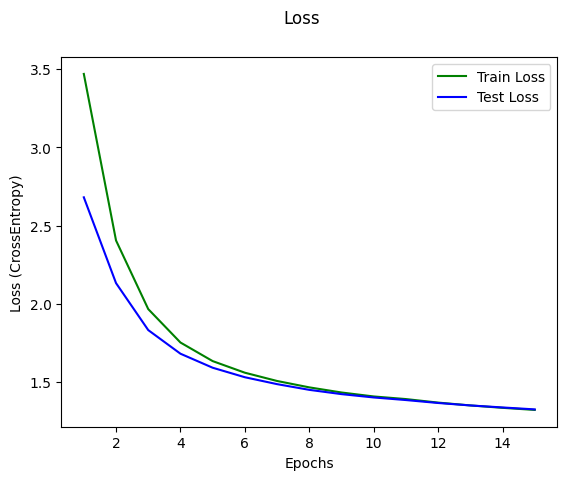

In [150]:
import matplotlib.pyplot as plt

fig = plt.figure(1)
fig.suptitle("Loss")

plt.plot(range(1, training_results.num_epochs + 1), training_results.train_loss, color='g', label='Train Loss')
plt.plot(range(1, training_results.num_epochs + 1), training_results.test_loss, color='b', label='Test Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (CrossEntropy)")
plt.legend()
plt.show()

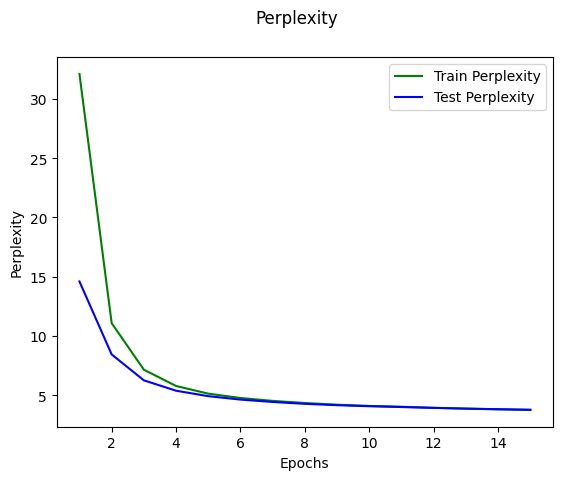

In [151]:
fig = plt.figure(1)
fig.suptitle("Perplexity")

plt.plot(range(1, training_results.num_epochs + 1), training_results.train_perplexity, color='g', label='Train Perplexity')
plt.plot(range(1, training_results.num_epochs + 1), training_results.test_perplexity, color='b', label='Test Perplexity')
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
plt.legend()
plt.show()

# Testing bot

In [179]:
class Chat:

    def __init__(self, model, device) -> None:
        self.model = model
        self.device = device
        self.context = []

    def generate_answer(self, question: str) -> str:
        
        with torch.inference_mode():
            model.eval()
            
            self.context.append(question)
            out = generate_output(self.context)
            answer = ' '.join([w2v.wv.index_to_key[index] for index in out])

            self.context.append(answer)
            return answer

In [180]:
c = Chat(model, device)

while True:
    try:
        print("Client> ", end='')
        question = input()
        print(question)
        answer = c.generate_answer(question)
        print("Agent> ", answer)
    except KeyboardInterrupt:
        break

Client> hello there please help me
Agent>  if you 've sent us the direct message , the email linked , had following a shot addresses , and we 'll update your device - 11.1.1 . and keep us posted if the one arrive ,
Client> i have a problem with my iphone
Agent>  we 'd be happy to assist with you . send us dm the ios version and we 'll go from there . that does n't sound right here :
Client> my ios is 11.1 and the battery started to drain quickly
Agent>  we try to the family steps . we 'll suggest there us here : /mu
Client> no don't do that
Agent>  here to help . send us a note at so our team can connect .
Client> i already sent you but no one responded
Agent>  we 'd love to help . please let us know out with your device . 2 : how here for be right . we are there on your order info . when we 'd love to provide that feature here here : ^pk
Client> bad agent
Agent>  when you have never exchange level of your update and our best team . kindly fill forward the with available options . it w

In [173]:
c2 = Chat(model, device)

while True:
    try:
        print("Client> ", end='')
        question = input()
        print(question)
        answer = c2.generate_answer(question)
        print("Agent> ", answer)
    except KeyboardInterrupt:
        break

Client> hello there can you help me with my package
Agent>  i 'm afraid we ca n't cause it wo n't help you soon now if the item , do you receive a demand delivery as delivery date : ^td
Client> i didn't even tell you the problem yet
Agent>  kindly check with this at the account seems from the additional form ( 1/2 ) ^cr
Client> hmm, you are speaking nonsense
Agent>  we 'll reach out to you with them ! if
Client> who are 'them'
Agent>  upload destinations balance & feedback ) , please reach us via twitter in english . contact us for help in with review these review :
Client> the package is marked as deliverd but I didn't receive it
Agent>  sorry for the delay ! we 'd like to provide your information via ; email ! ^dd
Client> good agent
Agent>  we 're so sorry for it ! send us a the bottom so we can further assist .
Client> 

In [181]:
c = Chat(model, device)

while True:
    try:
        print("Client> ", end='')
        question = input()
        print(question)
        answer = c.generate_answer(question)
        print("Agent> ", answer)
    except KeyboardInterrupt:
        break

Client> my uber driver was late and i was late to work 
Agent>  here to help ! send us a note via so our team can assist .
Client> i already sent you a dm but no one answered me
Agent>  have your order code and we 'd like to take a closer look on the situation . have you contact us here : we have received your details via email ?
Client> i don't understand what you mean
Agent>  ^sg
Client> what?
Agent>  that 's odd , but we did n't change available on features and hours shown , but you have any clarification as long reply by text to ship , but for worry ! you can check again while ja ?
Client> please i want you to refund my ride, i am not paying you a dime
Agent>  i 'm unable to get it comments were updated ? 2/2 i 'll see our sellers we have upset . kindly drop your details via twitter . ^ac
Client> 